# Runtime simulation

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
from scipy import sparse
import time

/home/mkim7/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


In [23]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'figure.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)


In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [6]:
import warnings
#warnings.warn('ignore')

In [22]:
%matplotlib inline

In [8]:
import sys
sys.path.append('/home/mkim7/Github/scrna-parameter-estimation/examples/simulation/')
import simulate as sim

In [9]:
data_path = '/data/parameter_estimation/interferon_data/'

In [10]:
import sys
sys.path.append('/home/mkim7/Github/scrna-parameter-estimation/scmemo')
import scmemo, utils

### Simulation

In [11]:
def convert_params(mu, theta):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    r = theta
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p

In [12]:
# Simluate the noise
p = 0.1
noise_level = 0.2049755522580501
p_sq = (noise_level+1)*p**2
m = p
v = p_sq - p**2
alpha = m*(m*(1-m)/v - 1)
beta = (1-m)*(m*(1-m)/v - 1)



In [13]:
def simulate_data(N, n_genes=5):
    
    # NB parameters
    nb_mean = stats.lognorm.rvs(s=0.5, scale=4)
    nb_theta = 1
    
    qs = stats.beta.rvs(alpha, beta, size=N)
    
    nb = stats.nbinom.rvs(*convert_params(nb_mean,nb_theta), size=(N, n_genes))
    
    nb_obs = stats.binom.rvs(n=nb, p=np.vstack([qs for i in range(n_genes)]).T)
    
    # Create an ann data out of these
    obs_df = pd.DataFrame()
    obs_df['n_counts'] = [1e10 for i in range(N)]
    obs_df['cell_type'] = np.random.choice(['A', 'B'], size=N)
    obs_df.index = obs_df.index.astype(str)
    #values = sparse.csr_matrix(nb_obs)
    adata = sc.AnnData(
        nb_obs, 
        var=pd.DataFrame(index=['gene_' + str(i) for i in range(1, n_genes+1)]),
        obs=obs_df)
    
    return adata

def time_hypothesis_test(adata):
    
    imp.reload(scmemo)
    estimator = scmemo.SingleCellEstimator(
        adata=adata, 
        group_label='cell_type',
        n_umis_column='n_counts',
        num_permute=10000,
        beta=0.1)
    estimator.beta_sq = p_sq
    
    estimator.compute_observed_moments('A')
    estimator.compute_observed_moments('-A')
    estimator.compute_observed_moments('B')
    estimator.compute_observed_moments('-B')    
    estimator.estimate_parameters()
    
    return estimator.compute_confidence_intervals_1d(
        groups=['A','B'],
        groups_to_compare=[('A', 'B')],
        gene_tracker_count=None, 
        timer='on')

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [14]:
num_cells = np.logspace(2, 6.5, 10);

In [16]:
all_count_times = []
all_compute_times = []
all_unique_counts = []
avg_count_times = np.zeros(num_cells.shape[0])
avg_compute_times = np.zeros(num_cells.shape[0])
avg_unique_counts = np.zeros(num_cells.shape[0])

num_trials=500
for idx, N in enumerate(num_cells):
    print('On cell count', N) 
    count_times = np.zeros(num_trials)
    compute_times = np.zeros(num_trials)
    unique_counts = np.zeros(num_trials)
    for trial in range(num_trials):
        data = simulate_data(int(N), n_genes=2)
        count_times[trial], compute_times[trial], unique_counts[trial] = time_hypothesis_test(data)
    all_count_times.append(count_times.copy())
    all_compute_times.append(compute_times.copy())
    all_unique_counts.append(unique_counts.copy())
    avg_count_times[idx]  = count_times.mean()
    avg_compute_times[idx] = compute_times.mean()
    avg_unique_counts[idx] = unique_counts.mean()

On cell count 100.0
On cell count 316.22776601683796


/home/mkim7/anaconda3/envs/single_cell/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
/home/mkim7/anaconda3/envs/single_cell/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/mkim7/anaconda3/envs/single_cell/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


On cell count 1000.0
On cell count 3162.2776601683795
On cell count 10000.0
On cell count 31622.776601683792
On cell count 100000.0
On cell count 316227.7660168379
On cell count 1000000.0
On cell count 3162277.6601683795


In [17]:
import pickle as pkl
with open('all_compute_times.pkl', 'wb') as f:
    pkl.dump(all_compute_times, f)
with open('all_count_times.pkl', 'wb') as f:
    pkl.dump(all_count_times, f)

In [19]:
with open('all_compute_times.pkl', 'rb') as f:
    all_compute_times = pkl.load(f)
with open('all_count_times.pkl', 'rb') as f:
    all_count_times = pkl.load(f)

In [20]:
skip = 1
x = num_cells[::skip]
y = [l.mean() for l in all_compute_times[::skip]]
yerr = [l.std() for l in all_compute_times[::skip]]

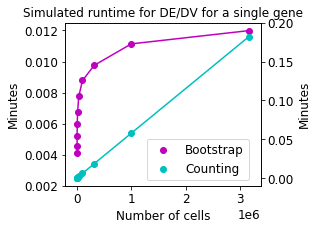

In [39]:
fig, ax1 = plt.subplots(figsize=(3.5, 3))
ax2 = ax1.twinx()

ax1.plot(num_cells[::skip], [l.mean()/2 for l in all_compute_times[::skip]], color='m')
ax1.scatter(
    x=num_cells[::skip],
    y=[l.mean()/2 for l in all_compute_times[::skip]],
    label='Bootstrap', color='m')

ax2.plot(num_cells[::skip], [l.mean()/2 for l in all_count_times[::skip]], color='c')
ax2.scatter(
    x=num_cells[::skip],
    y=[l.mean()/2 for l in all_count_times[::skip]],
    label='Counting', color='c')
plt.ticklabel_format(axis='x', style='sci', scilimits=(2, 6))
ax1.set_xlabel('Number of cells')
ax1.set_ylabel('Minutes')
ax2.set_ylabel('Minutes')
fig.legend(loc='best', bbox_to_anchor=(0.51, -0.05, 0.5, 0.5))
ax1.set_ylim(0.002, 0.0125)
ax2.set_ylim(-0.01, 0.2)
plt.title('Simulated runtime for DE/DV for a single gene')
plt.savefig('stimulated_runtime.pdf', bbox_inches='tight')

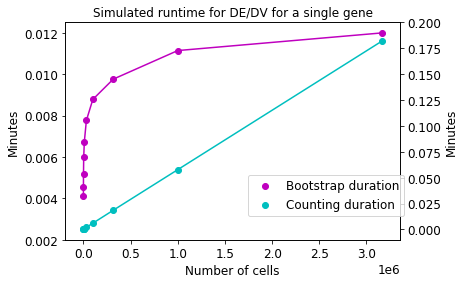

In [24]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(num_cells[::skip], [l.mean()/2 for l in all_compute_times[::skip]], color='m')
ax1.scatter(
    x=num_cells[::skip],
    y=[l.mean()/2 for l in all_compute_times[::skip]],
    label='Bootstrap duration', color='m')

ax2.plot(num_cells[::skip], [l.mean()/2 for l in all_count_times[::skip]], color='c')
ax2.scatter(
    x=num_cells[::skip],
    y=[l.mean()/2 for l in all_count_times[::skip]],
    label='Counting duration', color='c')
plt.ticklabel_format(axis='x', style='sci', scilimits=(2, 6))
ax1.set_xlabel('Number of cells')
ax1.set_ylabel('Minutes')
ax2.set_ylabel('Minutes')
fig.legend(loc='best', bbox_to_anchor=(0.45, -0.1, 0.5, 0.5))
ax1.set_ylim(0.002, 0.0125)
ax2.set_ylim(-0.01, 0.2)
plt.title('Simulated runtime for DE/DV for a single gene')
plt.savefig('stimulated_runtime.pdf', bbox_inches='tight')

### Interferon data - in jimmie's R01 grant

In [158]:
ifn_num_cells = np.array([100, 500, 1000, 2000, 3000, 5000, 10000, 20000])
ifn_times = np.array([
 20.869556665420532,
 35.29805541038513,
 38.040297746658325,
 46.348387002944946,
 58.43357753753662,
 87.58861637115479,
 142.3105809688568,
 222.7312273979187])

In [182]:
print(list(zip(num_cells, times)))

[(100.0, 6.929297208786011), (215.44346900318845, 12.625685453414917), (464.15888336127773, 6.224719762802124), (1000.0, 10.965573787689209), (2154.4346900318824, 9.975577116012573), (4641.588833612777, 14.064831018447876), (10000.0, 31.910074710845947), (21544.346900318822, 88.86108231544495), (46415.888336127726, 234.89731240272522), (100000.0, 339.7262473106384)]


In [184]:
sim_num_cells = np.array([   100.        ,    215.443469,  21544.34690032,
        46415.88833613, 100000.        ])
sim_times = np.array([
    6.92929721,  12.62568545,  88.86108232,
       234.8973124 , 339.72624731
])
sim_times = sim_times*(20.869556665420532/6.92929721)

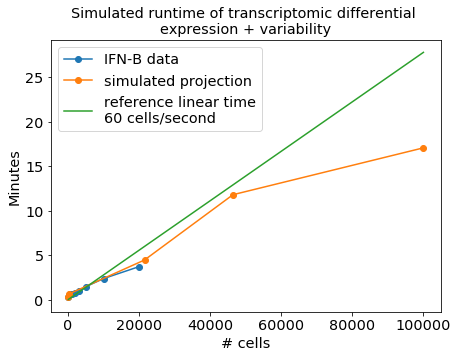

In [195]:
plt.figure(figsize=(7, 5))
plt.plot(ifn_num_cells, ifn_times/60, '-o', label='IFN-B data')
plt.plot(sim_num_cells, sim_times/60, '-o', label='simulated projection')
plt.plot(sim_num_cells, sim_num_cells/60/60, label='reference linear time\n60 cells/second')
plt.legend()
plt.title('Simulated runtime of transcriptomic differential \nexpression + variability')
plt.ylabel('Minutes');
plt.xlabel('# cells')
plt.savefig('simulated_sublinear_runtime.pdf', bbox_inches='tight')

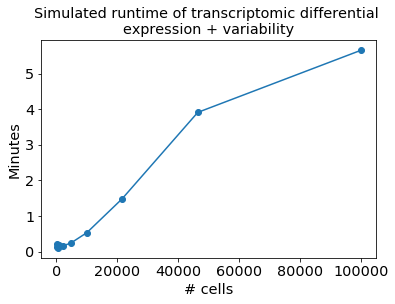

In [194]:
plt.plot(num_cells, times/60, '-o', label='runtime')
plt.title('Simulated runtime of transcriptomic differential \nexpression + variability')
plt.ylabel('Minutes');
plt.xlabel('# cells')
plt.savefig(data_path + 'figures/simulated_sublinear_runtime.pdf', bbox_inches='tight')

In [ ]:
plt.plot(times, np.array(perm_times)/60, '-o', label='runtime')
plt.plot(Ns, np.array(Ns)/60/60, label='ref. linear time\n60 cells/second')
plt.legend()
plt.title('Runtime of simulated transcriptomic differential \nexpression + variability')
plt.ylabel('Minutes');
plt.xlabel('# cells')
plt.savefig(data_path + 'figures/sublinear_runtime.pdf', bbox_inches='tight')